In [1]:
import os
import sys
train_done = True
study_id = 'original'
write_in_file = False

data_ = 'TransMut'

data_dir = '/home/s202357/thesis/transmut/data/transmut_github/'
model_folder = '/home/s202357/thesis/transmut/pipeline/{}/models/'.format(study_id)
result_folder = '/home/s202357/thesis/transmut/pipeline/{}/results/'.format(study_id)

In [2]:
!gpustat

hyperion                    Thu Jun 23 21:41:24 2022  470.103.01
[0] NVIDIA TITAN X (Pascal) | 21'C,   0 % |   947 / 12196 MB | ptab(943M)
[1] NVIDIA TITAN X (Pascal) | 26'C,   0 % |     4 / 12196 MB |
[2] NVIDIA TITAN X (Pascal) | 30'C,   0 % |     4 / 12196 MB |
[3] NVIDIA TITAN X (Pascal) | 22'C,   0 % |     4 / 12196 MB |
[4] NVIDIA TITAN X (Pascal) | 23'C,   0 % |     4 / 12196 MB |
[5] NVIDIA TITAN X (Pascal) | 23'C,   0 % |     4 / 12196 MB |
[6] NVIDIA TITAN X (Pascal) | 22'C,   0 % |     4 / 12196 MB |
[7] NVIDIA TITAN X (Pascal) | 23'C,   0 % |     4 / 12196 MB |


In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
from scipy import stats
import math
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
import datetime
import random
random.seed(1234)

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from functools import reduce
from tqdm import tqdm, trange
import seaborn as sn
from copy import deepcopy
from scipy import spatial

from IPython.display import HTML
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

import gc
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data


In [5]:
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/functions')
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/architecture')

import functions as fnc
from model_components import *

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
    print('There are %d GPU(s) avalable.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) avalable.


In [7]:
seed = 19961231
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [8]:
chart = [
[ ['1p', 'Blosum_ED', 20],           ['25p', 'Blosum_ED', 20],         ['75p', 'Blosum_ED', 20], ['100p', 'Blosum_ED', 20]],
[ ['1p', 'EmbeddingAttention', 4],   ['25p', 'EmbeddingAttention', 4],  ['75p', 'EmbeddingAttention', 4], ['100p', 'EmbeddingAttention', 4]],
[ ['1p', 'EmbeddingAttention', 20],  ['25p', 'EmbeddingAttention', 20], ['75p', 'EmbeddingAttention', 20], ['100p', 'EmbeddingAttention', 20]],    
[ ['1p', 'EmbeddingAttention', 32],  ['25p', 'EmbeddingAttention', 32], ['75p', 'EmbeddingAttention', 32], ['100p', 'EmbeddingAttention', 32]],
[ ['1p', 'EmbeddingAttention', 64],  ['25p', 'EmbeddingAttention', 64], ['75p', 'EmbeddingAttention', 64], ['100p', 'EmbeddingAttention', 64], ['100p', 'EmbeddingAttention', 128]]
]


blosum_dict = {
'A' : [5,-2,-1,-2,-1,-1,-1,0,-2,-1,-2,-1,-1,-3,-1,1,0,-3,-2,0],
'R' : [-2,7,-1,-2,-4,1,0,-3,0,-4,-3,3,-2,-3,-3,-1,-1,-3,-1,-3],
'N' : [-1,-1,7,2,-2,0,0,0,1,-3,-4,0,-2,-4,-2,1,0,-4,-2,-3],
'D' : [-2,-2,2,8,-4,0,2,-1,-1,-4,-4,-1,-4,-5,-1,0,-1,-5,-3,-4],
'C' : [-1,-4,-2,-4,13,-3,-3,-3,-3,-2,-2,-3,-2,-2,-4,-1,-1,-5,-3,-1],
'Q' : [-1,1,0,0,-3,7,2,-2,1,-3,-2,2,0,-4,-1,0,-1,-1,-1,-3],
'E' : [-1,0,0,2,-3,2,6,-3,0,-4,-3,1,-2,-3,-1,-1,-1,-3,-2,-3],
'G' : [0,-3,0,-1,-3,-2,-3,8,-2,-4,-4,-2,-3,-4,-2,0,-2,-3,-3,-4],
'H' : [-2,0,1,-1,-3,1,0,-2,10,-4,-3,0,-1,-1,-2,-1,-2,-3,2,-4],
'I' : [-1,-4,-3,-4,-2,-3,-4,-4,-4,5,2,-3,2,0,-3,-3,-1,-3,-1,4],
'L' : [-2,-3,-4,-4,-2,-2,-3,-4,-3,2,5,-3,3,1,-4,-3,-1,-2,-1,1],
'K' : [-1,3,0,-1,-3,2,1,-2,0,-3,-3,6,-2,-4,-1,0,-1,-3,-2,-3],
'M' : [-1,-2,-2,-4,-2,0,-2,-3,-1,2,3,-2,7,0,-3,-2,-1,-1,0,1],
'F' : [-3,-3,-4,-5,-2,-4,-3,-4,-1,0,1,-4,0,8,-4,-3,-2,1,4,-1],
'P' : [-1,-3,-2,-1,-4,-1,-1,-2,-2,-3,-4,-1,-3,-4,10,-1,-1,-4,-3,-3],
'S' : [1,-1,1,0,-1,0,-1,0,-1,-3,-3,0,-2,-3,-1,5,2,-4,-2,-2],
'T' : [0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,2,5,-3,-2,0],
'W' : [-3,-3,-4,-5,-5,-1,-3,-3,-3,-3,-2,-3,-1,1,-4,-4,-3,15,2,-3],
'Y' : [-2,-1,-2,-3,-3,-1,-2,-3,2,-1,-1,-2,0,4,-3,-2,-2,2,8,-1],
'V' : [0,-3,-3,-4,-1,-3,-3,-4,-4,4,1,-3,1,-1,-3,-2,0,-3,-1,5]
}


size_dict = {'1p':6000,
             '5p':30000,
             '25':150500,
             '50p':301000,
             '75':451500}

for key, val in zip(blosum_dict.keys(), blosum_dict.values()):
    if len(val) != 20:
        print(key +":"+ str(len(val)), end =", ")

In [9]:
cv = 5
count = 0
index_order = []

for outer in range(cv):
        test_idx = outer
        for inner in range(cv):
            if inner!=outer:
                val_idx = inner
                train_index = list()
                for t in range(5):
                    if t!=inner and t!=outer:
                        train_index.append(t)
                count += 1  
                index_order.append([test_idx, val_idx, train_index])
                
index_order_nested = index_order


In [10]:
pep_max_len = 14
hla_max_len = 34

tgt_len = pep_max_len + hla_max_len

d_ff = 512
n_layers, n_heads = 1, 3

batch_size = 1024
epochs = 25
threshold = 0.5

vocab = np.load( data_dir + 'Transformer_vocab_dict.npy', allow_pickle = True).item()
vocab_size = len(vocab)

model_info = chart[4][3]
size = model_info[0]   
model_type = model_info[1]
d_model = d_k = d_v = model_info[2]
model_abbr = 'ED'

print(size, model_type, d_model)

id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'
id_emb = 'OF_TData_pad14_{}_{}'
#id_emb = 'OF_TData_pad14_{}_EmbeddingAttention_200ep'

save_attn = True
save_attn_hla = False


100p EmbeddingAttention 64


In [ ]:
## TWO-SIDED BINOMIAL TEST, BASELINE, AUC 0.1 AND PPV:

In [27]:
print("-------------------------------------------------------")
for metric in ['AUC01', 'PPV']:
    d_model_list = [4, 20, 32, 64]

    print(metric)

    merged_list = []
    df_list = []
    median_list_emb = []
    mean_list_emb = []
    df_list_emb = []

    median_list_bl_emb = []
    mean_list_bl_emb = []
    df_list_bl_emb = []
    df_tag_list = []
    bin_list = []
    mean_list = []
    median_list= []

    size_list = ['05p', '1p', '5p', '25p', '50p', '75p', '100p']
    for size in size_list:

        id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
        id_emb = 'OF_TData_pad14_{}_{}_NOPOSCOMP'.format(size, 'onlyEmbedding')

        df_name = '{}_d{}_HLAperf.csv'.format(id_blosum,20)
        #print(df_name[53::])
        temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)#[['HLA','{}'.format(metric)]]

        if size == '05p':
            s = '<1%'
        else:
            s = size.replace('p', '%')
        temp_1['Datafraction'] = s
        temp_1['Method'] = 'BLOSUM'

        # ----
        md = np.median(list(temp_1[metric]))
        me = np.mean(list(temp_1[metric]))
        median_list.append(md)
        mean_list.append(me)
        median_list_bl_emb.append(md)
        mean_list_bl_emb.append(me)
        df_list_bl_emb.append(temp_1)
        df_list.append(temp_1)
        # ----

        tag_1 = size + '_onlyBlosum' + '_d20'
        #print(tag_1, 'added.')

        for d_model in d_model_list:

            fi = 'NOPOSCOMP'

            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)

            if size in ['75p']:
                fi = 'NOPOS'
                id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)

            if d_model in [20, 32] and size =='50p':
                fi = 'NOPOS'
                id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
                id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)

            if size =='100p':
                fi = 'PO'
                id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
                id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')

            df_name = '{}_d{}_HLAperf.csv'.format(id_emb,d_model)
            #print(df_name[53::])
            temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2['Datafraction'] = s
            temp_2['Method'] = 'Embedding-d{}'.format(d_model)



            df_list.append(temp_2)
            df_list_emb.append(temp_2)
            tag_2 = size + '_onlyEmbedding_d' + str(d_model)
            #print(tag_2, 'added.')

            md = np.median(list(temp_2[metric]))
            me = np.mean(list(temp_2[metric]))

            # ----
            temp_2_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2_bl_em['Datafraction'] = s
            temp_2_bl_em['Method'] = 'Embedding'.format(d_model)

            median_list.append(md)
            mean_list.append(me)
            mean_list_emb.append(me)
            median_list_emb.append(md)
            # ----

            merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

            equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

            second_wins = len(merged[merged['{}_x'.format(metric)] < merged['{}_y'.format(metric)]]['HLA'].tolist())

            pval = stats.binom_test(second_wins, n=112-equal, p=0.5, alternative='two-sided')

            if 'e' in str(pval):
                pval = str(float('{:0.3e}'.format(pval)))
            else:
                if 1 == pval:
                    pval = '1.0'
                else:
                    pval = str(round(pval,3))


            bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(112-second_wins-equal)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(second_wins)),  pval]]) 
            merged['type'] = tag_1 + " vs " + tag_2
            merged_list.append(merged)

            if size+str(d_model) in ['05p32', '1p64', '5p32', '25p32', '50p20', '75p20', '100p20']: #32 64 32 32 20 20 20
                df_list_bl_emb.append(temp_2_bl_em)
                median_list_bl_emb.append(md)
                mean_list_bl_emb.append(me)  
                print(bin_)


    df_concat_o = pd.concat(df_list)

    print("-------------------------------------------------------")

-------------------------------------------------------
AUC01
05p 05p_onlyBlosum_d20: 72 | Equal:0 | 05p_onlyEmbedding_d32: 40 | 0.003
1p 1p_onlyBlosum_d20: 50 | Equal:0 | 1p_onlyEmbedding_d64: 62 | 0.299
5p 5p_onlyBlosum_d20: 54 | Equal:0 | 5p_onlyEmbedding_d32: 58 | 0.777
25p 25p_onlyBlosum_d20: 33 | Equal:0 | 25p_onlyEmbedding_d32: 79 | 1.636e-05
50p 50p_onlyBlosum_d20: 50 | Equal:0 | 50p_onlyEmbedding_d20: 62 | 0.299
75p 75p_onlyBlosum_d20: 49 | Equal:0 | 75p_onlyEmbedding_d20: 63 | 0.219
100p 100p_onlyBlosum_d20: 44 | Equal:0 | 100p_onlyEmbedding_d20: 68 | 0.029
-------------------------------------------------------
PPV
05p 05p_onlyBlosum_d20: 70 | Equal:1 | 05p_onlyEmbedding_d32: 41 | 0.008
1p 1p_onlyBlosum_d20: 56 | Equal:8 | 1p_onlyEmbedding_d64: 48 | 0.493
5p 5p_onlyBlosum_d20: 47 | Equal:8 | 5p_onlyEmbedding_d32: 57 | 0.378
25p 25p_onlyBlosum_d20: 31 | Equal:8 | 25p_onlyEmbedding_d32: 73 | 4.657e-05
50p 50p_onlyBlosum_d20: 46 | Equal:8 | 50p_onlyEmbedding_d20: 58 | 0.281
75p

## TWO-SIDED BINOMIAL TEST, ATTN-BASED MODEL

In [36]:
print("-------------------------------------------------------")

for metric in ['AUC01', 'PPV']:
    d_model_list = [4, 20, 32, 64]

    print(metric)

    merged_list = []
    df_list = []
    median_list_emb = []
    mean_list_emb = []
    df_list_emb = []

    median_list_bl_emb = []
    mean_list_bl_emb = []
    df_list_bl_emb = []
    df_tag_list = []
    bin_list = []
    mean_list = []
    median_list = []

    size_list = ['05p', '1p', '25p', '75p', '100p']
    d_model_list = [4,20,32,64]

    merged_list = []
    df_list = []
    df_tag_list = []
    bin_list = []

    for size in size_list: 


        if size == '1p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
        elif size == '05p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
        else:
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'EmbeddingAttention')

        df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_blosum,20)
        temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)#[['HLA','{}'.format(metric)]]

        if size == '05p':
            s = '<1%'
        else:
            s = size.replace('p', '%')

        temp_1['Datafraction'] = s
        temp_1['Method'] = 'BLOSUM Attention'.format(20)
        df_list.append(temp_1)

        # ----
        md = np.median(list(temp_1[metric]))
        me = np.mean(list(temp_1[metric]))
        median_list.append(md)
        mean_list.append(me)
        median_list_bl_emb.append(md)
        mean_list_bl_emb.append(me)
        df_list_bl_emb.append(temp_1)
        df_list.append(temp_1)
        # ----

        tag_1 = size + 'BLOSUM-Attention' + '_d20'

        for d_model in d_model_list:

            df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_emb,d_model)

            temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2['Datafraction'] = s
            temp_2['Method'] = 'Embedding-Attention-d{}'.format(d_model)
            df_list.append(temp_2)
            tag_2 = size + 'Embedding-Attention-d' + str(d_model)

            md = np.median(list(temp_2[metric]))
            me = np.mean(list(temp_2[metric]))

            # ----
            temp_2_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2_bl_em['Datafraction'] = s
            temp_2_bl_em['Method'] = 'LE Attention'.format(d_model)


            median_list.append(md)
            mean_list.append(me)
            mean_list_emb.append(me)
            median_list_emb.append(md)
            df_list_emb.append(temp_2)
            # ----

            merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

            equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

            second_wins = len(merged[merged['{}_x'.format(metric)] < merged['{}_y'.format(metric)]]['HLA'].tolist())

            pval = stats.binom_test(second_wins, n=112-equal, p=0.5, alternative='two-sided')
            
            if 'e' in str(pval):
                pval = str(float('{:0.3e}'.format(pval)))
            else:
                if 1 == pval:
                    pval = '1.0'
                else:
                    pval = str(round(pval,3))
                
            bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(112-equal-second_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(second_wins)),  pval]])
            #df_temp = pd.DataFrame(bin_, columns = [size])

            if size+str(d_model) in ['05p20', '1p20', '25p20', '75p64', '100p64']: #32 64 32 32 20 20 20
                df_list_bl_emb.append(temp_2_bl_em)
                median_list_bl_emb.append(md)
                mean_list_bl_emb.append(me)
                print(bin_)



            md = np.median(list(temp_2[metric]))
            me = np.mean(list(temp_2[metric]))
            median_list.append(md)
            mean_list.append(me)

            merged['Method'] = tag_1 + " vs " + tag_2
            merged_list.append(merged)
            #bin_list.append(pd.DataFrame(bin_, columns = [size]))


    df_concat_o = pd.concat(df_list)
    print("-------------------------------------------------------")

    #ATTENTION

-------------------------------------------------------
AUC01
05p 05pBLOSUM-Attention_d20: 80 | Equal:0 | 05pEmbedding-Attention-d20: 32 | 6.566e-06
1p 1pBLOSUM-Attention_d20: 92 | Equal:0 | 1pEmbedding-Attention-d20: 20 | 3.188e-12
25p 25pBLOSUM-Attention_d20: 85 | Equal:0 | 25pEmbedding-Attention-d20: 27 | 3.58e-08
75p 75pBLOSUM-Attention_d20: 48 | Equal:0 | 75pEmbedding-Attention-d64: 64 | 0.156
100p 100pBLOSUM-Attention_d20: 41 | Equal:0 | 100pEmbedding-Attention-d64: 71 | 0.006
-------------------------------------------------------
PPV
05p 05pBLOSUM-Attention_d20: 79 | Equal:3 | 05pEmbedding-Attention-d20: 30 | 2.956e-06
1p 1pBLOSUM-Attention_d20: 91 | Equal:0 | 1pEmbedding-Attention-d20: 21 | 1.42e-11
25p 25pBLOSUM-Attention_d20: 67 | Equal:7 | 25pEmbedding-Attention-d20: 38 | 0.006
75p 75pBLOSUM-Attention_d20: 38 | Equal:9 | 75pEmbedding-Attention-d64: 65 | 0.01
100p 100pBLOSUM-Attention_d20: 37 | Equal:5 | 100pEmbedding-Attention-d64: 70 | 0.002
-------------------------------

### TWO-SIDED EMBEDDING VERSUS ATTENTION

AUC01
05p 05pBLOSUM-Baseline: 68 | Equal:0 | 05pBLOSUM-Attention64: 44 | 0.0293
1p 1pBLOSUM-Baseline: 47 | Equal:0 | 1pBLOSUM-Attention64: 65 | 0.1078
25p 25pBLOSUM-Baseline: 96 | Equal:0 | 25pBLOSUM-Attention64: 16 | 4.3777e-15
75p 75pBLOSUM-Baseline: 71 | Equal:0 | 75pBLOSUM-Attention64: 41 | 0.0059
100p 100pBLOSUM-Baseline: 57 | Equal:0 | 100pBLOSUM-Attention64: 55 | 0.9248


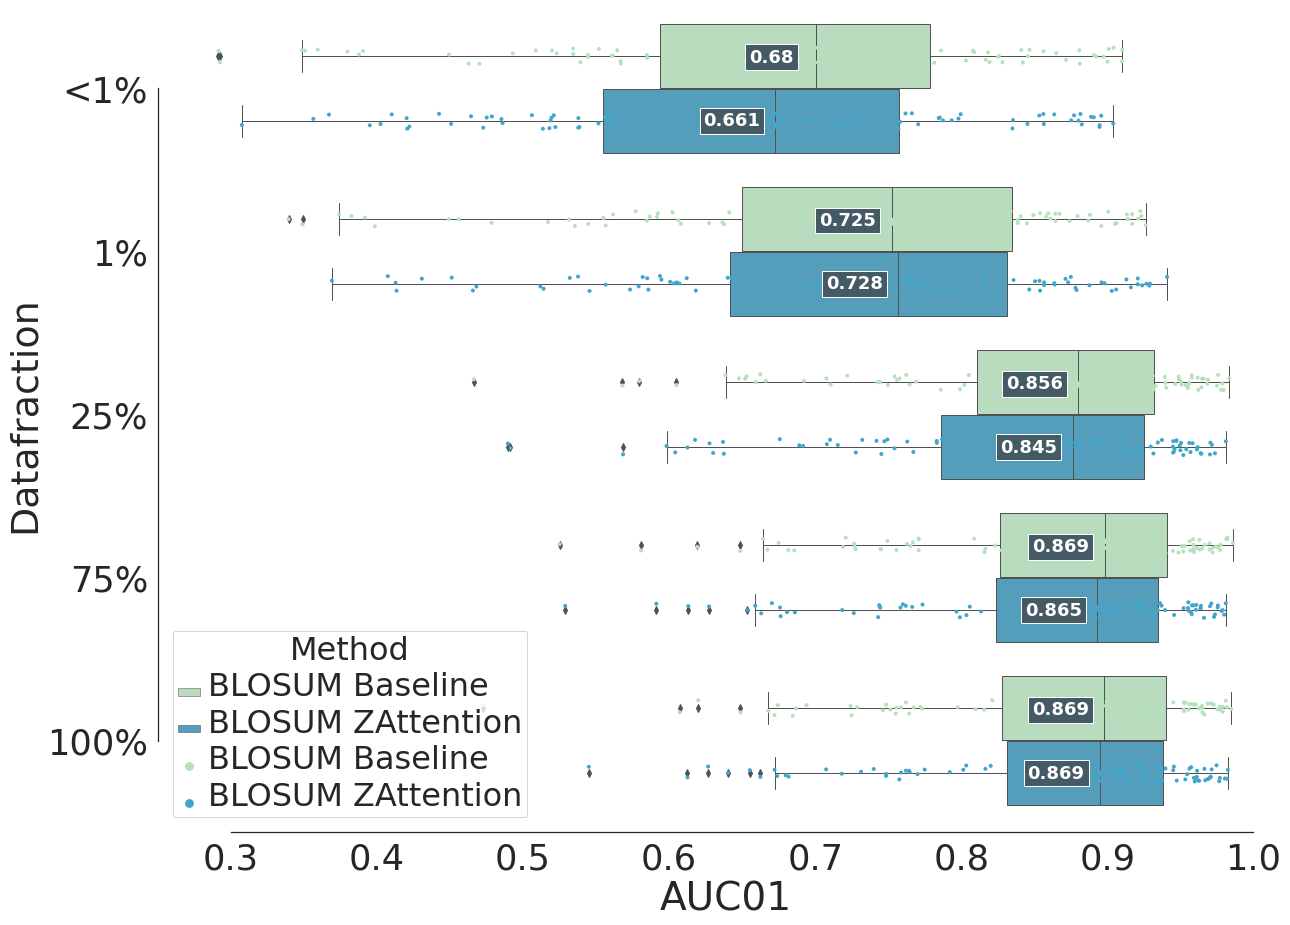

AUC01
05p 05pEmbedding-Baseline-d64: 75 | Equal:0 | 05pEmbedding-Attention-d20: 37 | 0.0004
1p 1pEmbedding-Baseline-d32: 80 | Equal:0 | 1pEmbedding-Attention-d20: 32 | 6.5663e-06
25p 25pEmbedding-Baseline-d32: 106 | Equal:0 | 25pEmbedding-Attention-d32: 6 | 9.7568e-25
75p 75pEmbedding-Baseline-d20: 67 | Equal:0 | 75pEmbedding-Attention-d64: 45 | 0.0467
100p 100pEmbedding-Baseline-d20: 47 | Equal:0 | 100pEmbedding-Attention-d64: 65 | 0.1078


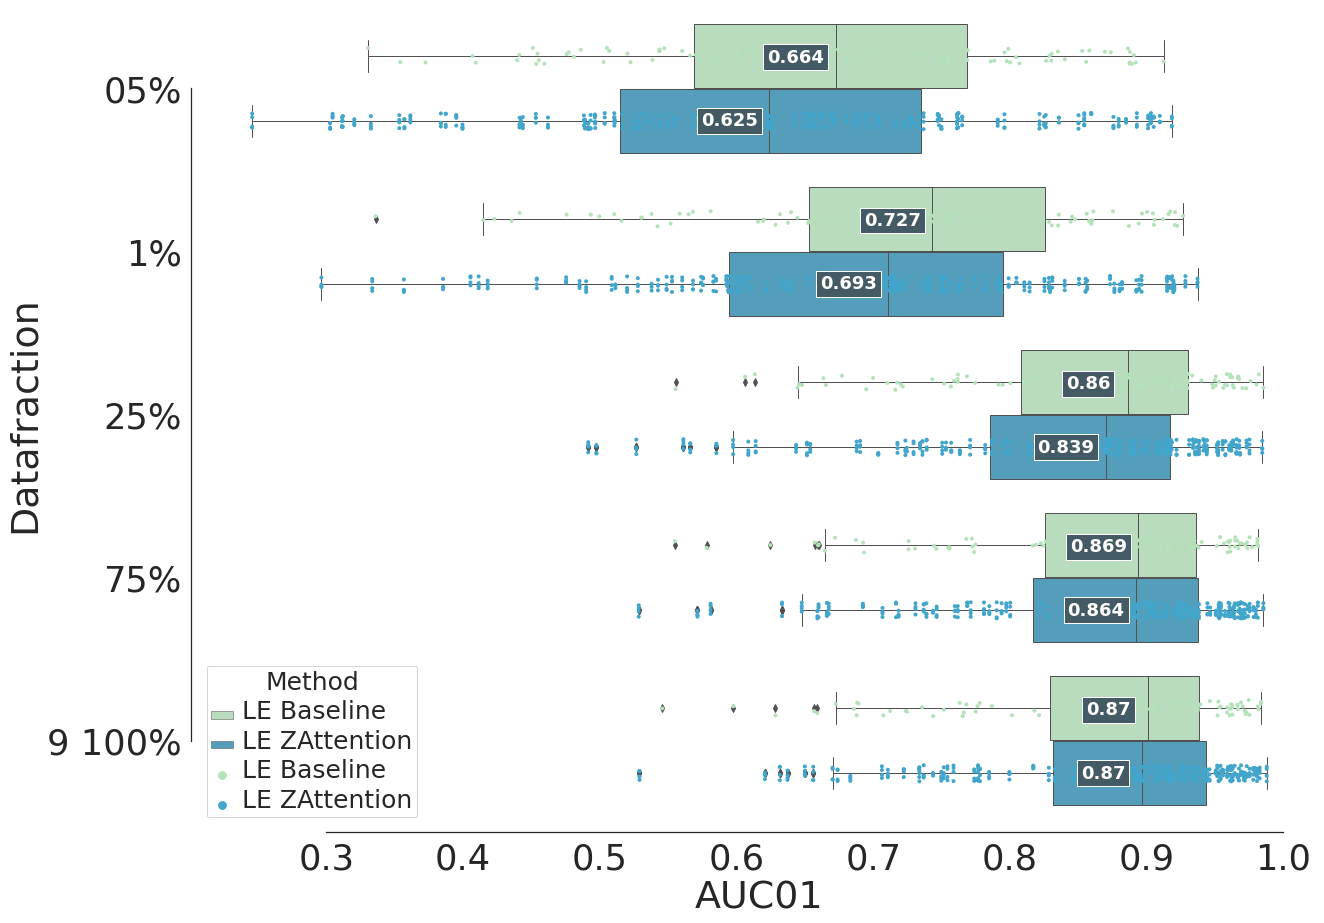

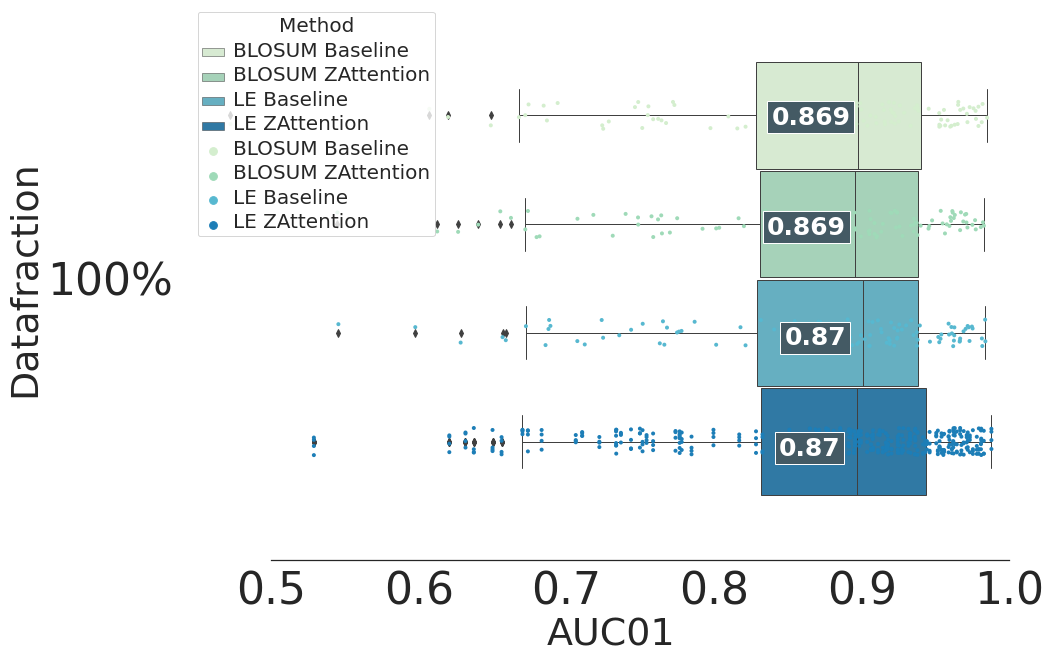

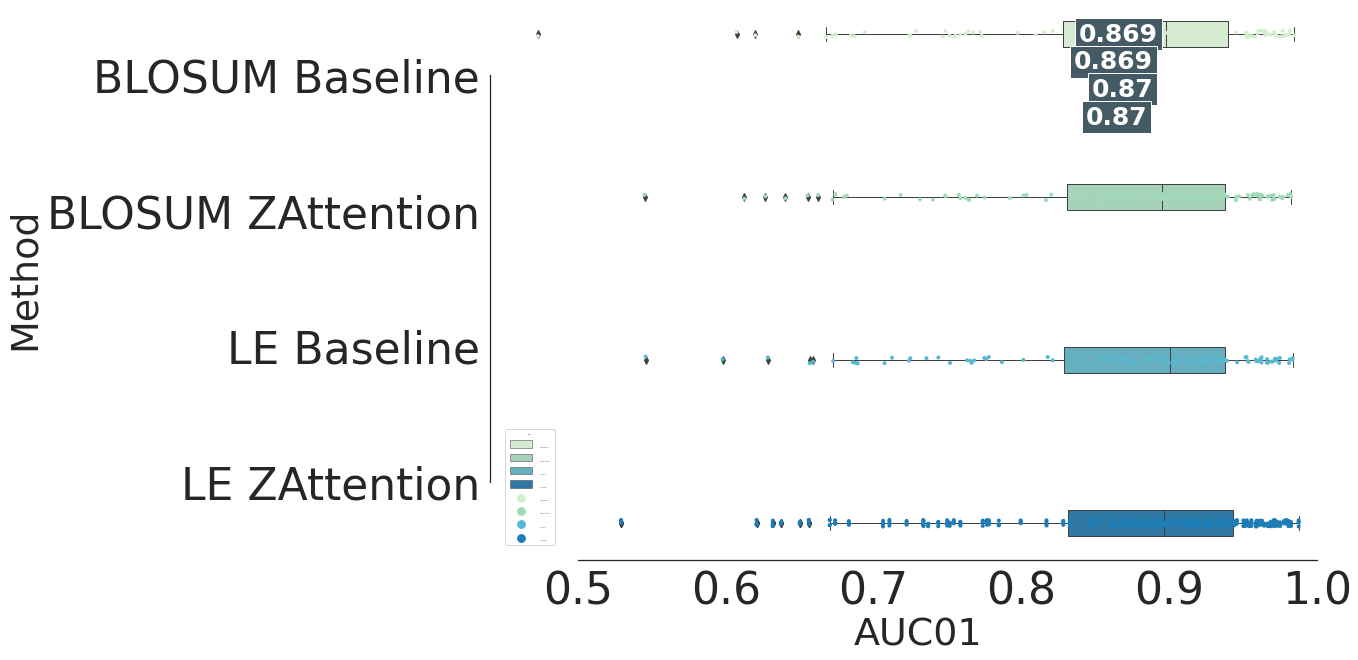

In [37]:
d_model_list = [4, 20, 32, 64]

metric = 'AUC01'
print(metric)

merged_list = []
df_list = []
median_list = []

median_list_emb = []
mean_list_emb = []
df_list_emb = []

but_me = []
but_md = []

median_list_bl_emb = []
mean_list_bl_emb = []
df_list_bl_emb = []
df_tag_list = []
bin_list = []
mean_list = []

save_list = []

size_list = ['05p', '1p', '25p', '75p', '100p']
d_model_list = [4, 20, 32, 64]

merged_list = []
df_list = []
df_tag_list = []
bin_list = []
tag_1_list = ['05p64', '1p32', '5p32', '25p32', '50p20', '75p20', '100p20']
tag_2_list = ['05p20', '1p20', '25p32', '75p64', '100p64']

for size in size_list: 
        
        save = False
        
        if size == '05p':
            s = '<1%'
        else:
            s = size.replace('p', '%')
    
        fi = 'NOPOSCOMP'
        
        id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
        id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
        
        if size in ['75p']:
            fi = 'NOPOS'
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if d_model in [20, 32] and size =='50p':
            fi = 'NOPOS'
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if size =='100p':
            save = True
            fi = 'PO'
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')
            
        df_name = '{}_d{}_HLAperf.csv'.format(id_blosum,20)

        temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_1['Datafraction'] = s
        temp_1['Method'] = 'BLOSUM'.format(d_model)
        
        df_list.append(temp_1)
        df_list_emb.append(temp_1)
        tag_1 = size + '_onlyBLOSUM_d' + str(d_model)
        
        md = np.median(list(temp_1[metric]))
        me = np.mean(list(temp_1[metric]))
        
        # ----
        df_name_1 = df_name
        
        temp_1_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_1_bl_em['Datafraction'] = s
        temp_1_bl_em['Method'] = 'BLOSUM Baseline'.format(d_model)
        
        tag_1_search = size+str(d_model)
            
        df_list_bl_emb.append(temp_1_bl_em)
            
        median_list.append(md)
        mean_list.append(me)
        mean_list_emb.append(me)
        median_list_emb.append(md)
        
        me_1 = me
        md_1 = md
        # ----

        tag_1 = size + 'BLOSUM-Baseline'.format(d_model)


        if size == '1p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
        elif size == '05p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
        else:
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'EmbeddingAttention')

        df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_blosum,20)

        temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2['Datafraction'] = s
        temp_2['Method'] = 'BLOSUM-Attention'.format(d_model)
        df_list.append(temp_2)
        tag_2 = size + 'BLOSUM-Attention' + str(d_model)

        
            
        md = np.median(list(temp_2[metric]))
        me = np.mean(list(temp_2[metric]))

        # ----
        temp_2_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2_bl_em['Datafraction'] = s
        temp_2_bl_em['Method'] = 'BLOSUM ZAttention'.format(d_model)
        
        if save:
            if d_model == 64:
                but_me.append(me)
                but_md.append(md)
                but_me.append(me_1)
                but_md.append(md_1)
                save_list.append(temp_1_bl_em)
                save_list.append(temp_2_bl_em)

        tag_2_search = size+str(d_model)

        df_list_bl_emb.append(temp_2_bl_em)

        median_list.append(md)
        mean_list.append(me)
        mean_list_emb.append(me)
        median_list_emb.append(md)
        df_list_emb.append(temp_2)
        # ----

        md_2 = md
        me_2 = me

        merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

        equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

        second_wins = len(merged[merged['{}_x'.format(metric)] < merged['{}_y'.format(metric)]]['HLA'].tolist())

        pval = stats.binom_test(second_wins, n=112-equal, p=0.5, alternative='two-sided')
        if 'e' in str(pval):
            pval = str(float('{:0.4e}'.format(pval)))
        else:
            if 1 == pval:
                pval = '1.0'
            else:
                pval = str(round(pval,4))
                
        bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(112-equal-second_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(second_wins)),  pval]])

        median_list_bl_emb.append(md_1)
        mean_list_bl_emb.append(me_1)
        median_list_bl_emb.append(md_2)
        mean_list_bl_emb.append(me_2)
        print(bin_)

        md = np.median(list(temp_2[metric]))
        me = np.mean(list(temp_2[metric]))
        median_list.append(md)
        mean_list.append(me)

        merged['Method'] = tag_1 + " vs " + tag_2
        merged_list.append(merged)
        #bin_list.append(pd.DataFrame(bin_, columns = [size]))
         

df_concat_o = pd.concat(df_list)

df_concat_o = pd.concat(df_list_bl_emb)
df_concat_o 

m1 = mean_list_bl_emb #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = median_list_bl_emb
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(20,15))

sn.boxplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=32)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=32)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=39)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=38)

sn.set(font_scale=3.2)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.8
for cat in range(5):
    y_add = 0.22
    x_ax_inc += y_add
    for subcat in range(2):
        x_ax_inc += 0.39
        #x_ax_inc_ = round(m1[idx],2)
        #print(x_ax_inc_)
        y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
        y_d = mL1_d[idx]
        y_list.append(y)
        ax.text(
            float(y_d)-0.03,
            x_ax_inc, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=18,
            color='white',
            bbox=dict(facecolor='#445A64'))
        
        idx += 1
        
plt.show()

d_model_list = [4, 20, 32, 64]


print(metric)

merged_list = []
df_list = []
median_list = []

median_list_emb = []
mean_list_emb = []
df_list_emb = []

median_list_bl_emb = []
mean_list_bl_emb = []
df_list_bl_emb = []
df_tag_list = []
bin_list = []
mean_list = []

size_list = ['05p', '1p', '25p', '75p', '100p']
d_model_list = [4,20,32,64]

merged_list = []
df_list = []
df_tag_list = []
bin_list = []

for size in size_list: 

    for d_model in d_model_list:
        
        save = False
        
        if size == '05p':
            s = '05 <1%'
        else:
            s = size.replace('p', '%')
            
        if size == '100p':
            s = '9 100%'
        else:
            s = size.replace('p', '%')
    
        fi = 'NOPOSCOMP'
        id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
        
        if size in ['75p']:
            fi = 'NOPOS'
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if d_model in [20, 32] and size =='50p':
            fi = 'NOPOS'
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if size =='100p':
            save = True
            fi = 'PO'
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')
            
        df_name = '{}_d{}_HLAperf.csv'.format(id_emb,d_model)
        #print(df_name[53::])
        temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_1['Datafraction'] = s
        temp_1['Method'] = 'Embedding-d{}'.format(d_model)
        
        df_list.append(temp_1)
        df_list_emb.append(temp_1)
        tag_1 = size + '_onlyEmbedding_d' + str(d_model)

        
        md = np.median(list(temp_1[metric]))
        me = np.mean(list(temp_1[metric]))
        
        # ----
        df_name_1 = df_name
        
        temp_1_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_1_bl_em['Datafraction'] = s
        temp_1_bl_em['Method'] = 'LE Baseline'.format(d_model)
        
        tag_1_search = size+str(d_model)
            
        if tag_1_search in tag_1_list: #32 64 32 32 20 20 20
            df_list_bl_emb.append(temp_1_bl_em)
            if save:
                    save_list.append(temp_1_bl_em)
                    but_me.append(me)
                    but_md.append(md)
            
    
                    
        median_list.append(md_1)
        mean_list.append(me_1)
        mean_list_emb.append(me_1)
        median_list_emb.append(md_1)
        me_1 = me
        md_1 = md
        # ----

        tag_1 = size + 'Embedding-Baseline-d{}'.format(d_model)

        for d_model in d_model_list:
            
            if size == '1p':
                id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
                id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
            elif size == '05p':
                id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
                id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
            else:
                id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'.format(size, 'Blosum_ED')
                id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'EmbeddingAttention')

            df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_emb,d_model)

            temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2['Datafraction'] = s
            temp_2['Method'] = 'Embedding-Attention-d{}'.format(d_model)
            df_list.append(temp_2)
            tag_2 = size + 'Embedding-Attention-d' + str(d_model)

            md = np.median(list(temp_2[metric]))
            me = np.mean(list(temp_2[metric]))

            # ----
            temp_2_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2_bl_em['Datafraction'] = s
            temp_2_bl_em['Method'] = 'LE ZAttention'.format(d_model)

            tag_2_search = size+str(d_model)
            
            if tag_2_search in tag_2_list: #32 64 32 32 20 20 20
                df_list_bl_emb.append(temp_2_bl_em)
                if save:
                    but_me.append(me)
                    but_md.append(md)
                    save_list.append(temp_2_bl_em)

            median_list.append(md)
            mean_list.append(me)
            mean_list_emb.append(me)
            median_list_emb.append(md)

            df_list_emb.append(temp_2)
            # ----
            
            

            md_2 = md
            me_2 = me
            
            merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

            equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

            second_wins = len(merged[merged['{}_x'.format(metric)] < merged['{}_y'.format(metric)]]['HLA'].tolist())

            pval = stats.binom_test(second_wins, n=112-equal, p=0.5, alternative='two-sided')
            if 'e' in str(pval):
                pval = str(float('{:0.4e}'.format(pval)))
            else:
                if 1 == pval:
                    pval = '1.0'
                else:
                    pval = str(round(pval,4))

            bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(112-equal-second_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(second_wins)),  pval]])
            
            #df_temp = pd.DataFrame(bin_, columns = [size])
            if tag_1_search in tag_1_list:
                if tag_2_search in tag_2_list:

                    median_list_bl_emb.append(md_1)
                    mean_list_bl_emb.append(me_1)
                    
                    median_list_bl_emb.append(md_2)
                    mean_list_bl_emb.append(me_2)
                    #print(df_name_1[11:50], " | ",  df_name[70:122])
                    print(bin_)

            md = np.median(list(temp_2[metric]))
            me = np.mean(list(temp_2[metric]))
            median_list.append(md)
            mean_list.append(me)

            merged['Method'] = tag_1 + " vs " + tag_2
            merged_list.append(merged)
            #bin_list.append(pd.DataFrame(bin_, columns = [size]))
          

df_concat_o = pd.concat(df_list)

df_concat_o = pd.concat(df_list_bl_emb)
df_concat_o = df_concat_o.sort_values(["Datafraction", "Method"])
df_concat_o


m1 = mean_list_bl_emb #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = median_list_bl_emb
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(20,15))

sn.boxplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=25)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=25)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=38)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=38)

sn.set(font_scale=3.2)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.8
for cat in range(5):
    y_add = 0.22
    x_ax_inc += y_add
    for subcat in range(2):
        x_ax_inc += 0.39
        #x_ax_inc_ = round(m1[idx],2)
        #print(x_ax_inc_)
        y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
        y_d = mL1_d[idx]
        y_list.append(y)
        ax.text(
            float(y_d)-0.029,
            x_ax_inc, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=18,
            color='white',
            bbox=dict(facecolor='#445A64'))
        
        idx += 1
        
plt.show()



save_list_concat = pd.concat(save_list)
save_list_concat['Datafraction'] = '100%'
save_list_concat = save_list_concat.sort_values(by='Method')


m1 = [0.8694388338060701, 0.8688771550372462, 0.8703599675312833, 0.8701017319197738] #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = [0.8977400184364658, 0.8951557796479761, 0.9007551083420864, 0.8967492205503771]
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(15,10))

sn.boxplot(x=metric, y='Datafraction', hue="Method", data=save_list_concat,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Datafraction', hue="Method", data=save_list_concat, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=20)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=20)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=38)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=38)

sn.set(font_scale=4)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.5
for cat in range(4):
    y_add = 0.003
    x_ax_inc += y_add
    x_ax_inc += 0.2
    #x_ax_inc_ = round(m1[idx],2)
    #print(x_ax_inc_)
    y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
    y_d = mL1_d[idx]
    y_list.append(y)
    ax.text(
        float(y_d)-0.0325,
        x_ax_inc, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=25,
        color='white',
        bbox=dict(facecolor='#445A64'))

    idx += 1
        
plt.show()



m1 = [0.8694388338060701, 0.8688771550372462, 0.8703599675312833, 0.8701017319197738] #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = [0.8977400184364658, 0.8951557796479761, 0.9007551083420864, 0.8967492205503771]
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(15,10))
save_list_concat = save_list_concat[save_list_concat['Datafraction']=='100%']
sn.boxplot(x=metric, y='Method', hue="Method", data=save_list_concat,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Method', hue="Method", data=save_list_concat, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=1)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=1)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=38)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=38)

sn.set(font_scale=4)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.5
for cat in range(4):
    y_add = 0.003
    x_ax_inc += y_add
    x_ax_inc += 0.2
    #x_ax_inc_ = round(m1[idx],2)
    #print(x_ax_inc_)
    y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
    y_d = mL1_d[idx]
    y_list.append(y)
    ax.text(
        float(y_d)-0.0325,
        x_ax_inc, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=25,
        color='white',
        bbox=dict(facecolor='#445A64'))

    idx += 1
        
plt.show()


PPV
05p 05pBLOSUM-Baseline: 76 | Equal:5 | 05pBLOSUM-Attention64: 31 | 1.6029e-05
1p 1pBLOSUM-Baseline: 59 | Equal:4 | 1pBLOSUM-Attention64: 49 | 0.3866
25p 25pBLOSUM-Baseline: 85 | Equal:7 | 25pBLOSUM-Attention64: 20 | 1.0083e-10
75p 75pBLOSUM-Baseline: 72 | Equal:7 | 75pBLOSUM-Attention64: 33 | 0.0002
100p 100pBLOSUM-Baseline: 58 | Equal:8 | 100pBLOSUM-Attention64: 46 | 0.2807


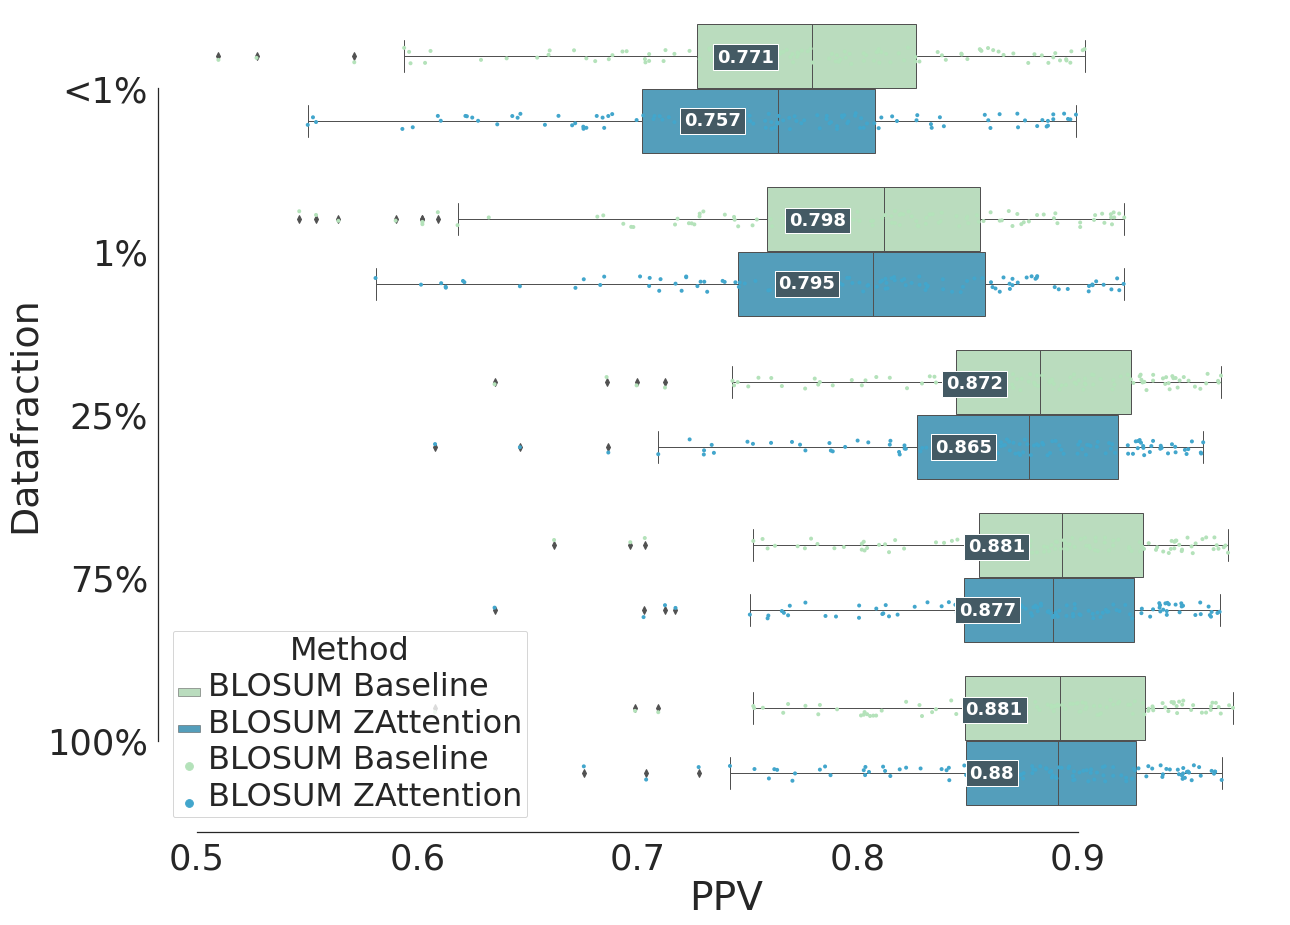

PPV
05p 05pEmbedding-Baseline-d64: 80 | Equal:3 | 05pEmbedding-Attention-d20: 29 | 1.0809e-06
1p 1pEmbedding-Baseline-d32: 82 | Equal:2 | 1pEmbedding-Attention-d20: 28 | 2.5194e-07
25p 25pEmbedding-Baseline-d32: 95 | Equal:10 | 25pEmbedding-Attention-d32: 7 | 7.8496e-21
75p 75pEmbedding-Baseline-d20: 56 | Equal:8 | 75pEmbedding-Attention-d64: 48 | 0.4926
100p 100pEmbedding-Baseline-d20: 46 | Equal:18 | 100pEmbedding-Attention-d64: 48 | 0.9179


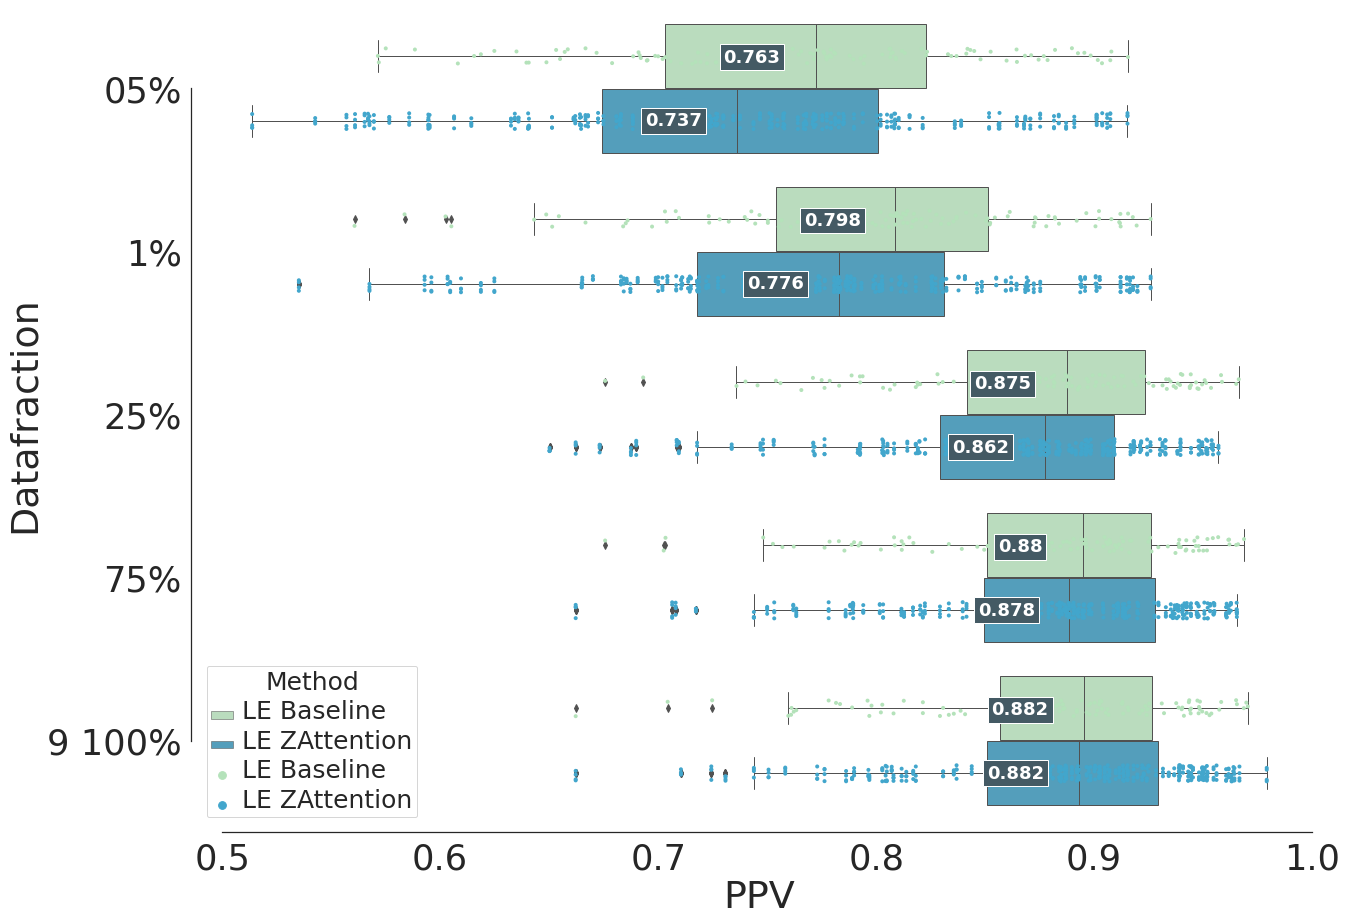

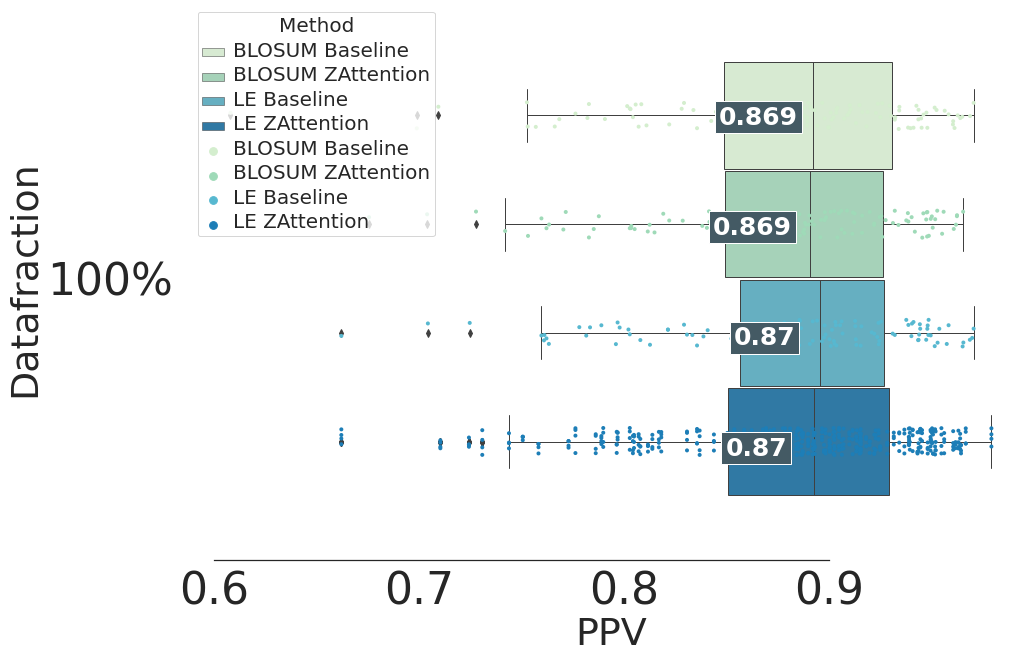

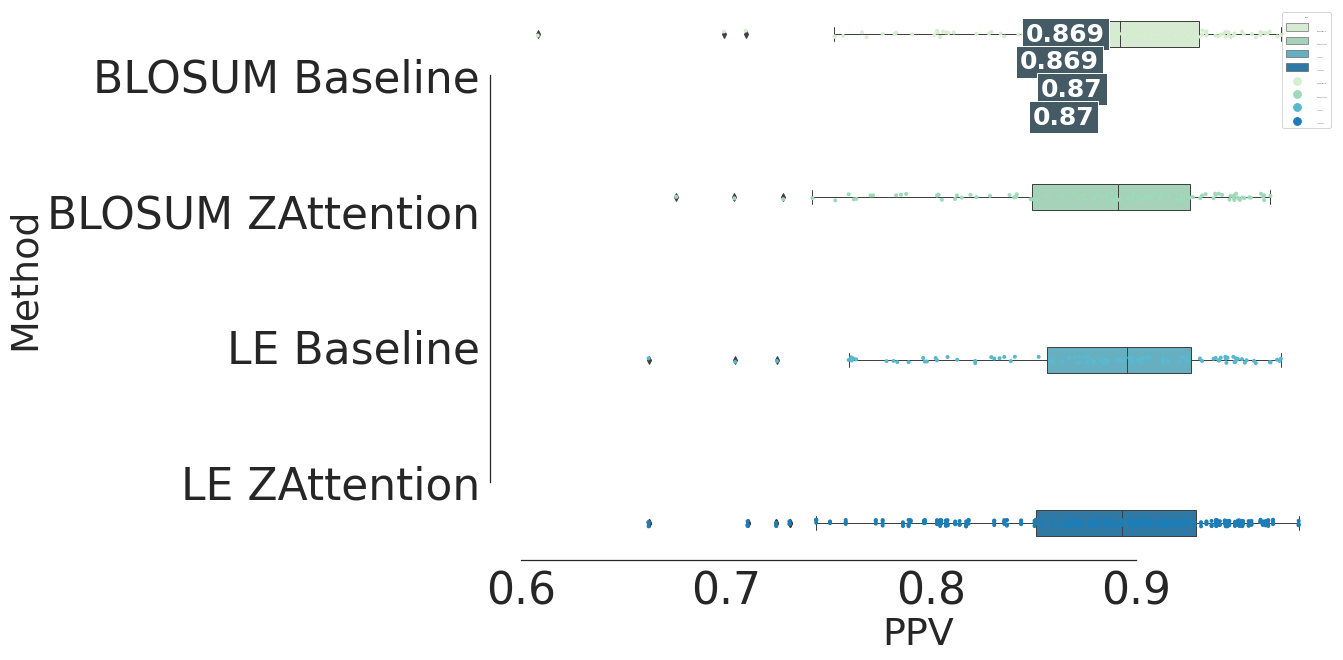

In [38]:
d_model_list = [4, 20, 32, 64]

metric = 'PPV'
print(metric)

merged_list = []
df_list = []
median_list = []

median_list_emb = []
mean_list_emb = []
df_list_emb = []

but_me = []
but_md = []

median_list_bl_emb = []
mean_list_bl_emb = []
df_list_bl_emb = []
df_tag_list = []
bin_list = []
mean_list = []

save_list = []

size_list = ['05p', '1p', '25p', '75p', '100p']
d_model_list = [4, 20, 32, 64]

merged_list = []
df_list = []
df_tag_list = []
bin_list = []
tag_1_list = ['05p64', '1p32', '5p32', '25p32', '50p20', '75p20', '100p20']
tag_2_list = ['05p20', '1p20', '25p32', '75p64', '100p64']

for size in size_list: 
        
        save = False
        
        if size == '05p':
            s = '<1%'
        else:
            s = size.replace('p', '%')
    
        fi = 'NOPOSCOMP'
        
        id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
        id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
        
        if size in ['75p']:
            fi = 'NOPOS'
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if d_model in [20, 32] and size =='50p':
            fi = 'NOPOS'
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if size =='100p':
            save = True
            fi = 'PO'
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_NOPOS'.format(size, 'onlyBlosum')
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')
            
        df_name = '{}_d{}_HLAperf.csv'.format(id_blosum,20)

        temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_1['Datafraction'] = s
        temp_1['Method'] = 'BLOSUM'.format(d_model)
        
        df_list.append(temp_1)
        df_list_emb.append(temp_1)
        tag_1 = size + '_onlyBLOSUM_d' + str(d_model)
        
        md = np.median(list(temp_1[metric]))
        me = np.mean(list(temp_1[metric]))
        
        # ----
        df_name_1 = df_name
        
        temp_1_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_1_bl_em['Datafraction'] = s
        temp_1_bl_em['Method'] = 'BLOSUM Baseline'.format(d_model)
        
        tag_1_search = size+str(d_model)
            
        df_list_bl_emb.append(temp_1_bl_em)
            
        median_list.append(md)
        mean_list.append(me)
        mean_list_emb.append(me)
        median_list_emb.append(md)
        
        me_1 = me
        md_1 = md
        # ----

        tag_1 = size + 'BLOSUM-Baseline'.format(d_model)


        if size == '1p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
        elif size == '05p':
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
        else:
            id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'.format(size, 'Blosum_ED')
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'EmbeddingAttention')

        df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_blosum,20)

        temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2['Datafraction'] = s
        temp_2['Method'] = 'BLOSUM-Attention'.format(d_model)
        df_list.append(temp_2)
        tag_2 = size + 'BLOSUM-Attention' + str(d_model)

        
            
        md = np.median(list(temp_2[metric]))
        me = np.mean(list(temp_2[metric]))

        # ----
        temp_2_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_2_bl_em['Datafraction'] = s
        temp_2_bl_em['Method'] = 'BLOSUM ZAttention'.format(d_model)
        
        if save:
            if d_model == 64:
                but_me.append(me)
                but_md.append(md)
                but_me.append(me_1)
                but_md.append(md_1)
                save_list.append(temp_1_bl_em)
                save_list.append(temp_2_bl_em)

        tag_2_search = size+str(d_model)

        df_list_bl_emb.append(temp_2_bl_em)

        median_list.append(md)
        mean_list.append(me)
        mean_list_emb.append(me)
        median_list_emb.append(md)
        df_list_emb.append(temp_2)
        # ----

        md_2 = md
        me_2 = me

        merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

        equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

        second_wins = len(merged[merged['{}_x'.format(metric)] < merged['{}_y'.format(metric)]]['HLA'].tolist())

        pval = stats.binom_test(second_wins, n=112-equal, p=0.5, alternative='two-sided')
        if 'e' in str(pval):
            pval = str(float('{:0.4e}'.format(pval)))
        else:
            if 1 == pval:
                pval = '1.0'
            else:
                pval = str(round(pval,4))
                
        bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(112-equal-second_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(second_wins)),  pval]])

        median_list_bl_emb.append(md_1)
        mean_list_bl_emb.append(me_1)
        median_list_bl_emb.append(md_2)
        mean_list_bl_emb.append(me_2)
        print(bin_)

        md = np.median(list(temp_2[metric]))
        me = np.mean(list(temp_2[metric]))
        median_list.append(md)
        mean_list.append(me)

        merged['Method'] = tag_1 + " vs " + tag_2
        merged_list.append(merged)
        #bin_list.append(pd.DataFrame(bin_, columns = [size]))
         

df_concat_o = pd.concat(df_list)

df_concat_o = pd.concat(df_list_bl_emb)
df_concat_o 

m1 = mean_list_bl_emb #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = median_list_bl_emb
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(20,15))

sn.boxplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=32)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=32)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=39)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=38)

sn.set(font_scale=3.2)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.8
for cat in range(5):
    y_add = 0.22
    x_ax_inc += y_add
    for subcat in range(2):
        x_ax_inc += 0.39
        #x_ax_inc_ = round(m1[idx],2)
        #print(x_ax_inc_)
        y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
        y_d = mL1_d[idx]
        y_list.append(y)
        ax.text(
            float(y_d)-0.03,
            x_ax_inc, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=18,
            color='white',
            bbox=dict(facecolor='#445A64'))
        
        idx += 1
        
plt.show()

d_model_list = [4, 20, 32, 64]


print(metric)

merged_list = []
df_list = []
median_list = []

median_list_emb = []
mean_list_emb = []
df_list_emb = []

median_list_bl_emb = []
mean_list_bl_emb = []
df_list_bl_emb = []
df_tag_list = []
bin_list = []
mean_list = []

size_list = ['05p', '1p', '25p', '75p', '100p']
d_model_list = [4,20,32,64]

merged_list = []
df_list = []
df_tag_list = []
bin_list = []

for size in size_list: 

    for d_model in d_model_list:
        
        save = False
        
        if size == '05p':
            s = '05 <1%'
        else:
            s = size.replace('p', '%')
            
        if size == '100p':
            s = '9 100%'
        else:
            s = size.replace('p', '%')
    
        fi = 'NOPOSCOMP'
        id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
        
        if size in ['75p']:
            fi = 'NOPOS'
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if d_model in [20, 32] and size =='50p':
            fi = 'NOPOS'
            id_emb = 'OF_TData_pad14_{}_{}_{}'.format(size, 'onlyEmbedding', fi)
            
        if size =='100p':
            save = True
            fi = 'PO'
            id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'onlyEmbedding')
            
        df_name = '{}_d{}_HLAperf.csv'.format(id_emb,d_model)
        #print(df_name[53::])
        temp_1 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_1['Datafraction'] = s
        temp_1['Method'] = 'Embedding-d{}'.format(d_model)
        
        df_list.append(temp_1)
        df_list_emb.append(temp_1)
        tag_1 = size + '_onlyEmbedding_d' + str(d_model)

        
        md = np.median(list(temp_1[metric]))
        me = np.mean(list(temp_1[metric]))
        
        # ----
        df_name_1 = df_name
        
        temp_1_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
        temp_1_bl_em['Datafraction'] = s
        temp_1_bl_em['Method'] = 'LE Baseline'.format(d_model)
        
        tag_1_search = size+str(d_model)
            
        if tag_1_search in tag_1_list:
            df_list_bl_emb.append(temp_1_bl_em)
            if save:
                    save_list.append(temp_1_bl_em)
                    but_me.append(me)
                    but_md.append(md)
            
    
                    
        median_list.append(md_1)
        mean_list.append(me_1)
        mean_list_emb.append(me_1)
        median_list_emb.append(md_1)
        me_1 = me
        md_1 = md
        # ----

        tag_1 = size + 'Embedding-Baseline-d{}'.format(d_model)

        for d_model in d_model_list:
            
            if size == '1p':
                id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
                id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
            elif size == '05p':
                id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'.format(size, 'Blosum_ED')
                id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'.format(size, 'EmbeddingAttention')
            else:
                id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'.format(size, 'Blosum_ED')
                id_emb = 'OF_TData_pad14_{}_{}'.format(size, 'EmbeddingAttention')

            df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_emb,d_model)

            temp_2 = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2['Datafraction'] = s
            temp_2['Method'] = 'Embedding-Attention-d{}'.format(d_model)
            df_list.append(temp_2)
            tag_2 = size + 'Embedding-Attention-d' + str(d_model)

            md = np.median(list(temp_2[metric]))
            me = np.mean(list(temp_2[metric]))

            # ----
            temp_2_bl_em = pd.read_csv(df_name, names = ['HLA','AUC', 'AUC01', 'PPV'], header=0)
            temp_2_bl_em['Datafraction'] = s
            temp_2_bl_em['Method'] = 'LE ZAttention'.format(d_model)

            tag_2_search = size+str(d_model)
            
            if tag_2_search in tag_2_list: #32 64 32 32 20 20 20
                df_list_bl_emb.append(temp_2_bl_em)
                if save:
                    but_me.append(me)
                    but_md.append(md)
                    save_list.append(temp_2_bl_em)

            median_list.append(md)
            mean_list.append(me)
            mean_list_emb.append(me)
            median_list_emb.append(md)

            df_list_emb.append(temp_2)
            # ----
            
            

            md_2 = md
            me_2 = me
            
            merged = temp_1.merge(temp_2,on='HLA').sort_values(by = ['HLA'])

            equal = len(merged[merged['{}_x'.format(metric)] == merged['{}_y'.format(metric)]]['HLA'].tolist())

            second_wins = len(merged[merged['{}_x'.format(metric)] < merged['{}_y'.format(metric)]]['HLA'].tolist())

            pval = stats.binom_test(second_wins, n=112-equal, p=0.5, alternative='two-sided')
            if 'e' in str(pval):
                pval = str(float('{:0.4e}'.format(pval)))
            else:
                if 1 == pval:
                    pval = '1.0'
                else:
                    pval = str(round(pval,4))

            bin_ = ' '.join([ str(x) for x in [size, "{}: {}".format(tag_1, str(112-equal-second_wins)), "| Equal:{}".format(equal), "| {}: {} |".format(tag_2, str(second_wins)),  pval]])
            
            #df_temp = pd.DataFrame(bin_, columns = [size])
            if tag_1_search in tag_1_list:
                if tag_2_search in tag_2_list:

                    median_list_bl_emb.append(md_1)
                    mean_list_bl_emb.append(me_1)
                    
                    median_list_bl_emb.append(md_2)
                    mean_list_bl_emb.append(me_2)
                    #print(df_name_1[11:50], " | ",  df_name[70:122])
                    print(bin_)

            md = np.median(list(temp_2[metric]))
            me = np.mean(list(temp_2[metric]))
            median_list.append(md)
            mean_list.append(me)

            merged['Method'] = tag_1 + " vs " + tag_2
            merged_list.append(merged)
            #bin_list.append(pd.DataFrame(bin_, columns = [size])) 

df_concat_o = pd.concat(df_list)

df_concat_o = pd.concat(df_list_bl_emb)
df_concat_o = df_concat_o.sort_values(["Datafraction", "Method"])
df_concat_o


m1 = mean_list_bl_emb #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = median_list_bl_emb
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(20,15))

sn.boxplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Datafraction', hue="Method", data=df_concat_o, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=25)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=25)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=38)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=38)

sn.set(font_scale=3.2)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.8
for cat in range(5):
    y_add = 0.22
    x_ax_inc += y_add
    for subcat in range(2):
        x_ax_inc += 0.39
        #x_ax_inc_ = round(m1[idx],2)
        #print(x_ax_inc_)
        y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
        y_d = mL1_d[idx]
        y_list.append(y)
        ax.text(
            float(y_d)-0.029,
            x_ax_inc, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=18,
            color='white',
            bbox=dict(facecolor='#445A64'))
        
        idx += 1
        
plt.show()



save_list_concat = pd.concat(save_list)
save_list_concat['Datafraction'] = '100%'
save_list_concat = save_list_concat.sort_values(by='Method')


m1 = [0.8694388338060701, 0.8688771550372462, 0.8703599675312833, 0.8701017319197738] #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = [0.8977400184364658, 0.8951557796479761, 0.9007551083420864, 0.8967492205503771]
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(15,10))

sn.boxplot(x=metric, y='Datafraction', hue="Method", data=save_list_concat,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Datafraction', hue="Method", data=save_list_concat, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=20)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=20)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=38)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=38)

sn.set(font_scale=4)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.5
for cat in range(4):
    y_add = 0.003
    x_ax_inc += y_add
    x_ax_inc += 0.2
    #x_ax_inc_ = round(m1[idx],2)
    #print(x_ax_inc_)
    y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
    y_d = mL1_d[idx]
    y_list.append(y)
    ax.text(
        float(y_d)-0.0325,
        x_ax_inc, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=25,
        color='white',
        bbox=dict(facecolor='#445A64'))

    idx += 1
        
plt.show()



m1 = [0.8694388338060701, 0.8688771550372462, 0.8703599675312833, 0.8701017319197738] #median_list
mL1 = [str(np.round(s,3)) for s in m1]

m1_d = [0.8977400184364658, 0.8951557796479761, 0.9007551083420864, 0.8967492205503771]
mL1_d = [str(np.round(s,3)) for s in m1_d]


palette = 'GnBu'

metric = metric

sn.set(style='white')

#sn.set(style="ticks")


fig, ax = plt.subplots(figsize=(15,10))
save_list_concat = save_list_concat[save_list_concat['Datafraction']=='100%']
sn.boxplot(x=metric, y='Method', hue="Method", data=save_list_concat,  palette=palette, linewidth=1)
sn.stripplot(x=metric, y='Method', hue="Method", data=save_list_concat, palette=palette, size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu

for ax in plt.gcf().axes:
    plt.setp(ax.get_legend().get_texts(), fontsize=1)  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=1)  # for legend title

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=38)

for ax in plt.gcf().axes:
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=38)

sn.set(font_scale=4)

sn.despine(offset=10, trim=True)

ax_ = ax.axes
lines = ax_.get_lines()
categories = ax_.get_xticks()

idx = 0
y_list = []
x_ax_inc = -0.5
for cat in range(4):
    y_add = 0.003
    x_ax_inc += y_add
    x_ax_inc += 0.2
    #x_ax_inc_ = round(m1[idx],2)
    #print(x_ax_inc_)
    y = mL1[idx] #round(lines[4+subcat*6].get_ydata()[0],5)
    y_d = mL1_d[idx]
    y_list.append(y)
    ax.text(
        float(y_d)-0.0325,
        x_ax_inc, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=25,
        color='white',
        bbox=dict(facecolor='#445A64'))

    idx += 1
        
plt.show()


#EMB VERSUS ATTN - TWO-SIDED
AUC01
05p 05pEmbedding-Baseline-d64: 75 | Equal:0 | 05pEmbedding-Attention-d20: 37 | 0.0004
1p 1pEmbedding-Baseline-d32: 80 | Equal:0 | 1pEmbedding-Attention-d20: 32 | 6.5663e-06
25p 25pEmbedding-Baseline-d32: 106 | Equal:0 | 25pEmbedding-Attention-d32: 6 | 9.7568e-25
75p 75pEmbedding-Baseline-d20: 67 | Equal:0 | 75pEmbedding-Attention-d64: 45 | 0.0467
100p 100pEmbedding-Baseline-d20: 47 | Equal:0 | 100pEmbedding-Attention-d64: 65 | 0.1078

PPV
05p 05pEmbedding-Baseline-d64: 80 | Equal:3 | 05pEmbedding-Attention-d20: 29 | 1.0809e-06
1p 1pEmbedding-Baseline-d32: 82 | Equal:2 | 1pEmbedding-Attention-d20: 28 | 2.5194e-07
25p 25pEmbedding-Baseline-d32: 95 | Equal:10 | 25pEmbedding-Attention-d32: 7 | 7.8496e-21
75p 75pEmbedding-Baseline-d20: 56 | Equal:8 | 75pEmbedding-Attention-d64: 48 | 0.4926
100p 100pEmbedding-Baseline-d20: 46 | Equal:18 | 100pEmbedding-Attention-d64: 48 | 0.9179
            